# Implémentez un modèle de scoring

## Import

In [38]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time

# Visu
import missingno as msno
import seaborn as sns
import matplotlib. pyplot as plt

# utils
import utils

# MLFlow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# Sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

## Data

In [39]:
df_app = pd.read_csv('Data/application_train.csv')

### Aperçu des données

Check des valeurs manquantes, duplicata, type et dimension de nos données

In [40]:
df_app.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

<AxesSubplot: >

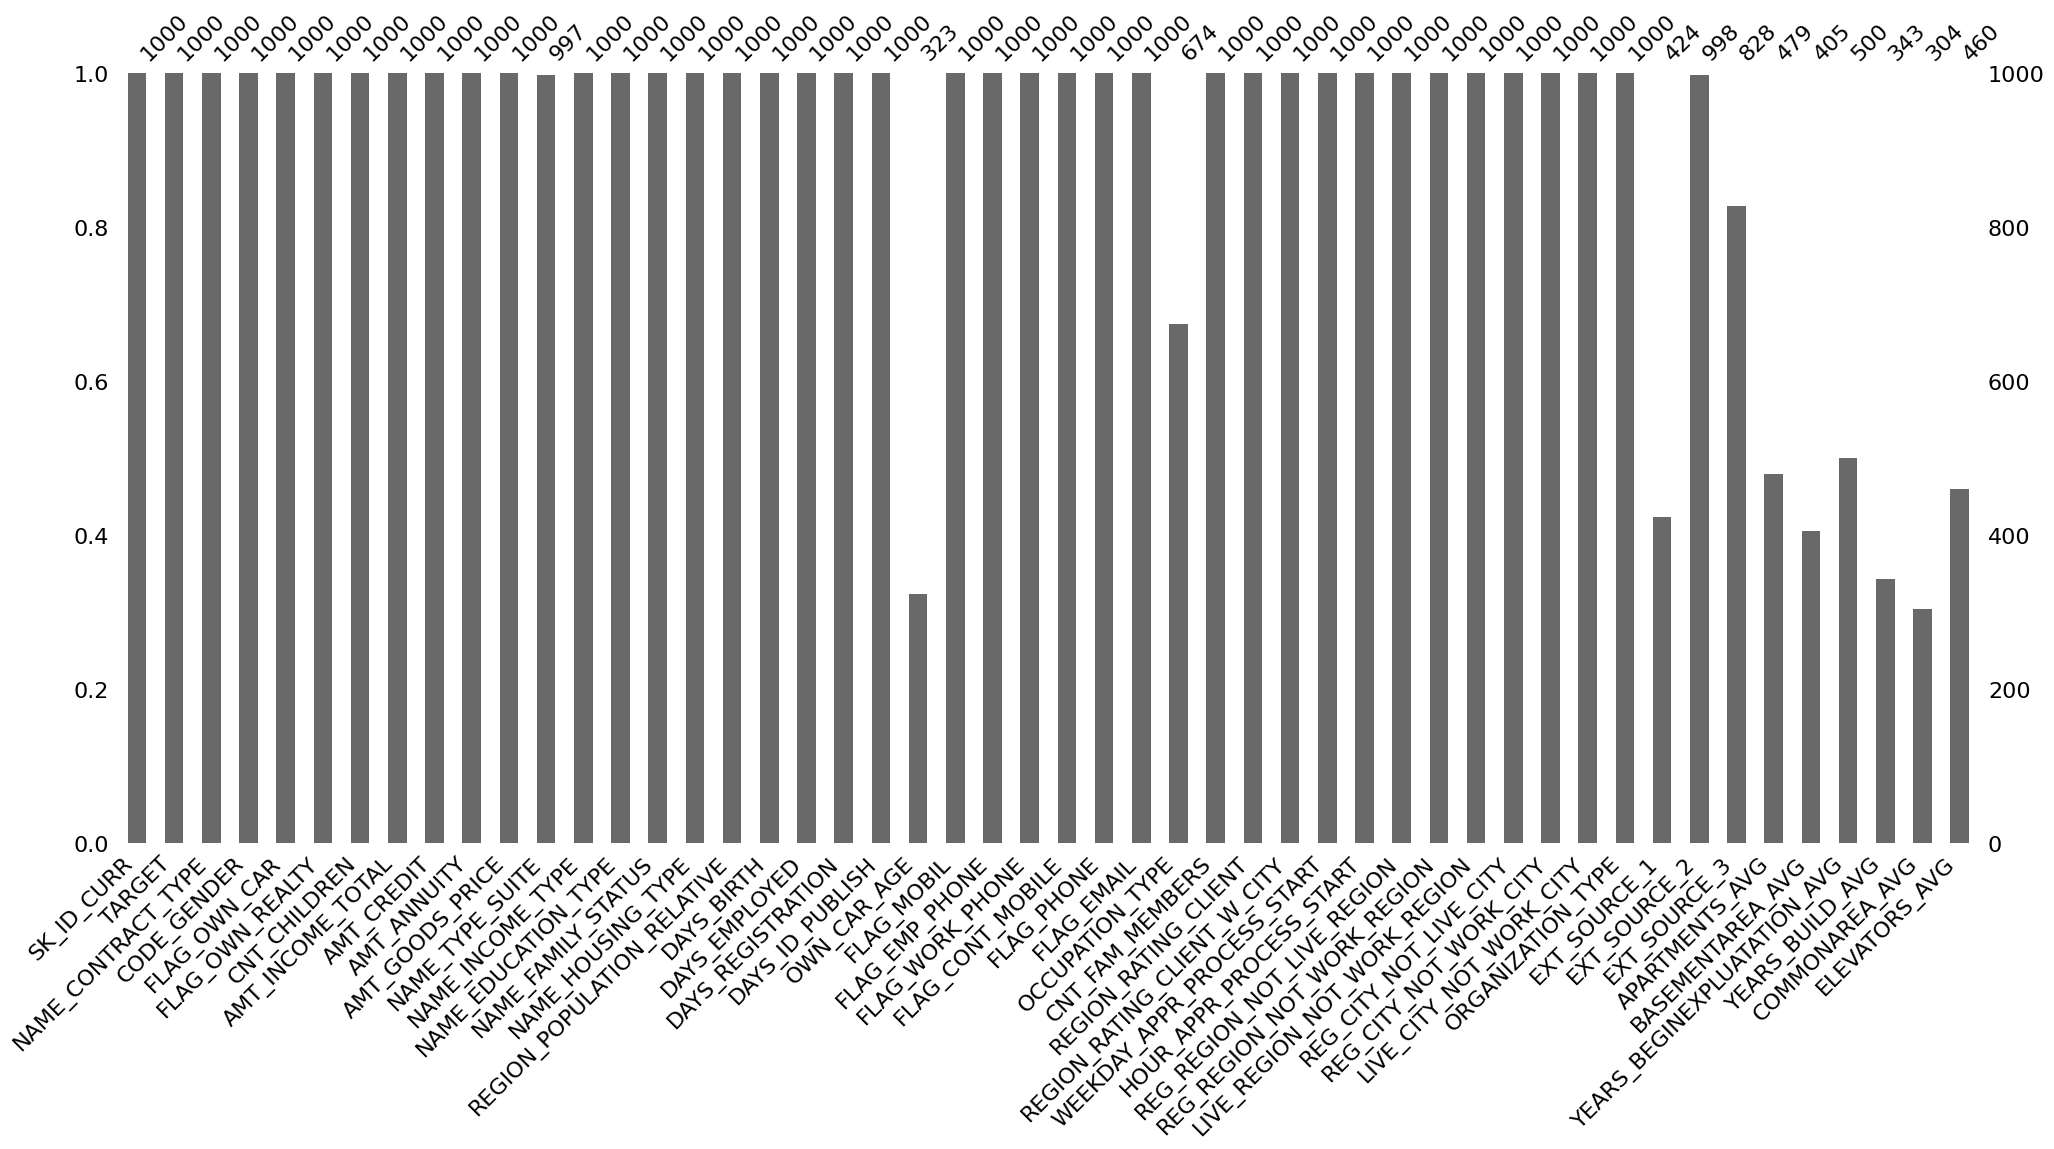

In [41]:
msno.bar(df_app.iloc[:, 0:50].sample(1000))

<AxesSubplot: >

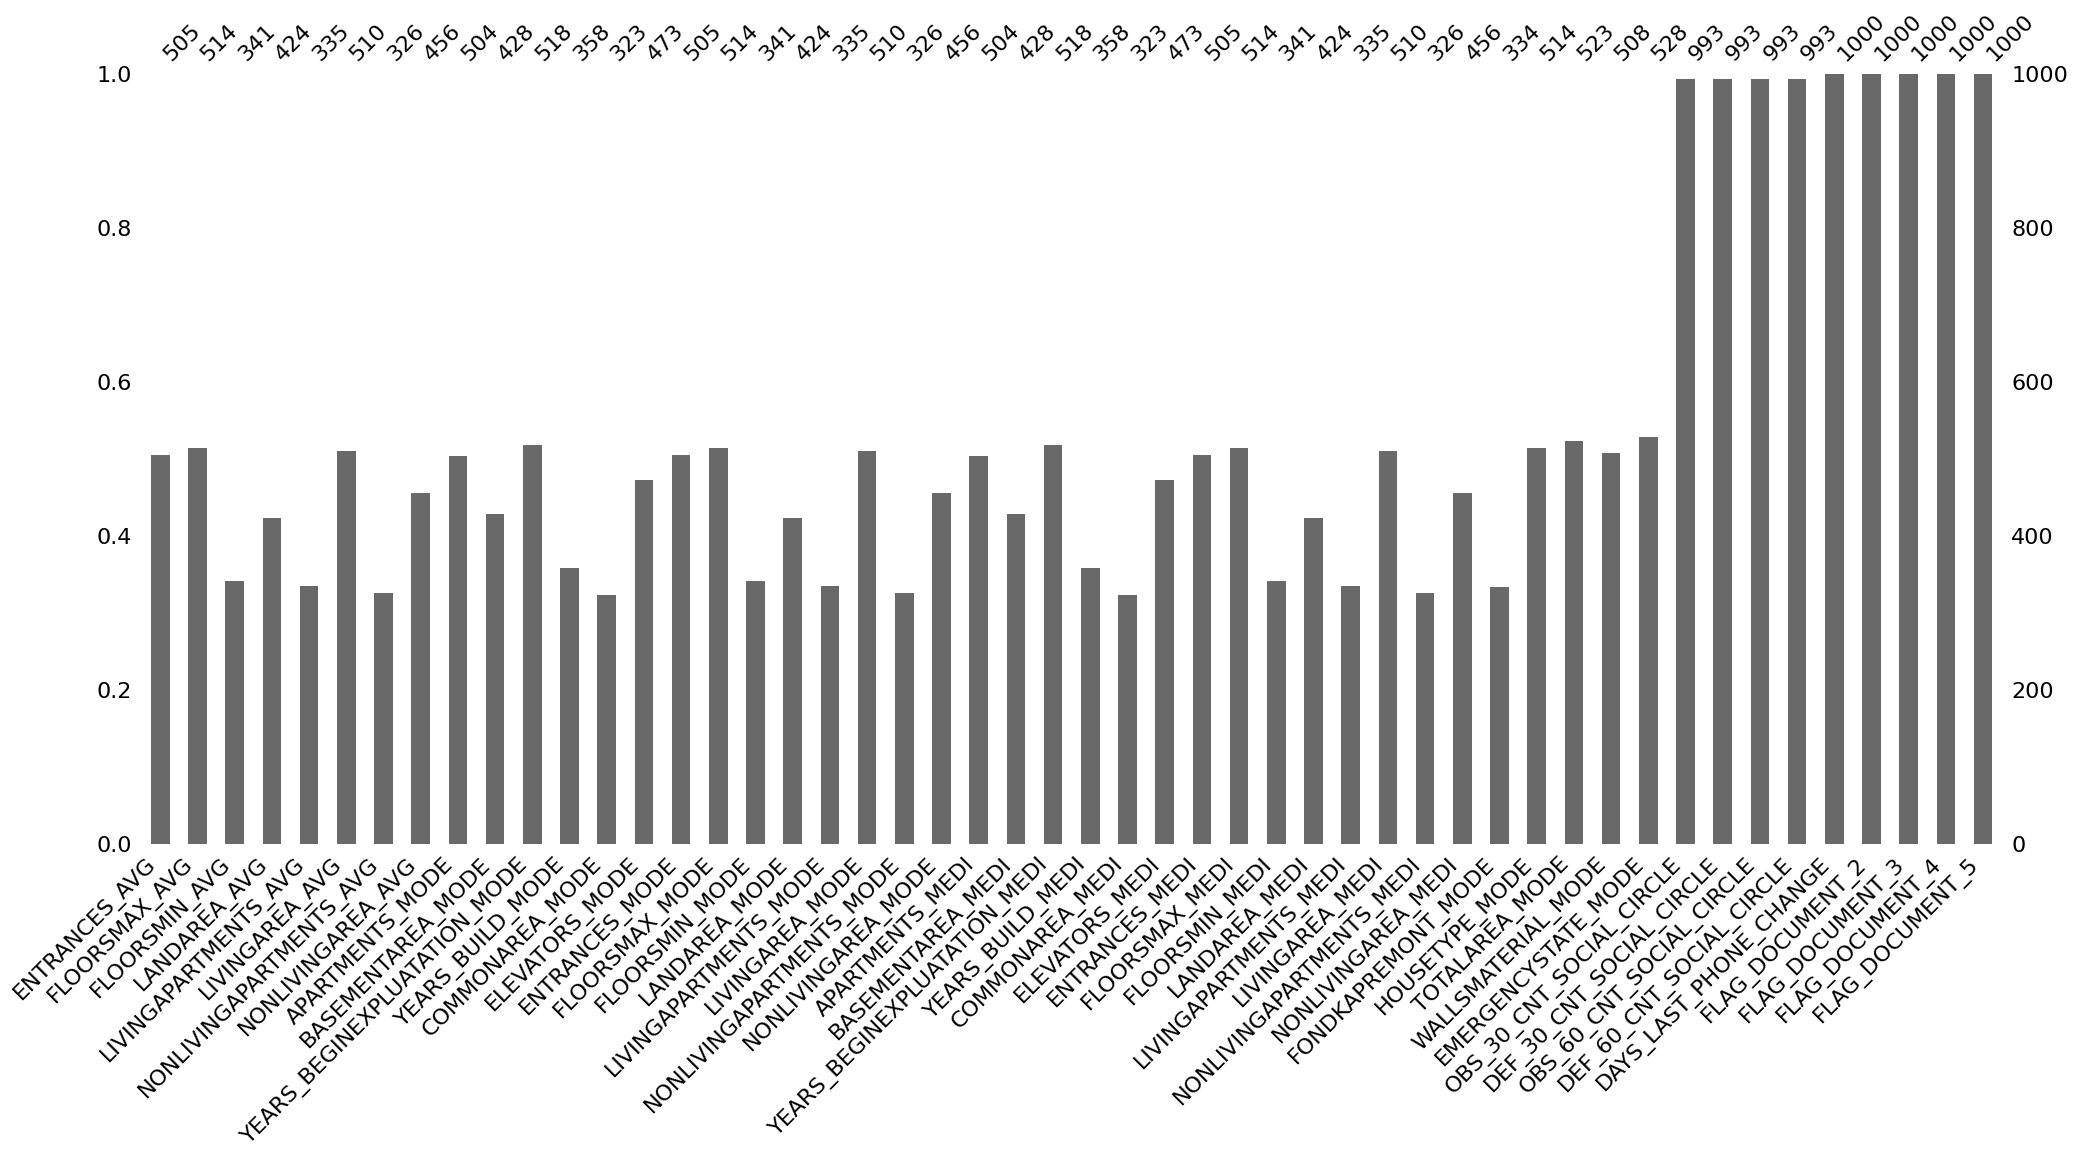

In [42]:
msno.bar(df_app.iloc[:, 50:100].sample(1000))

<AxesSubplot: >

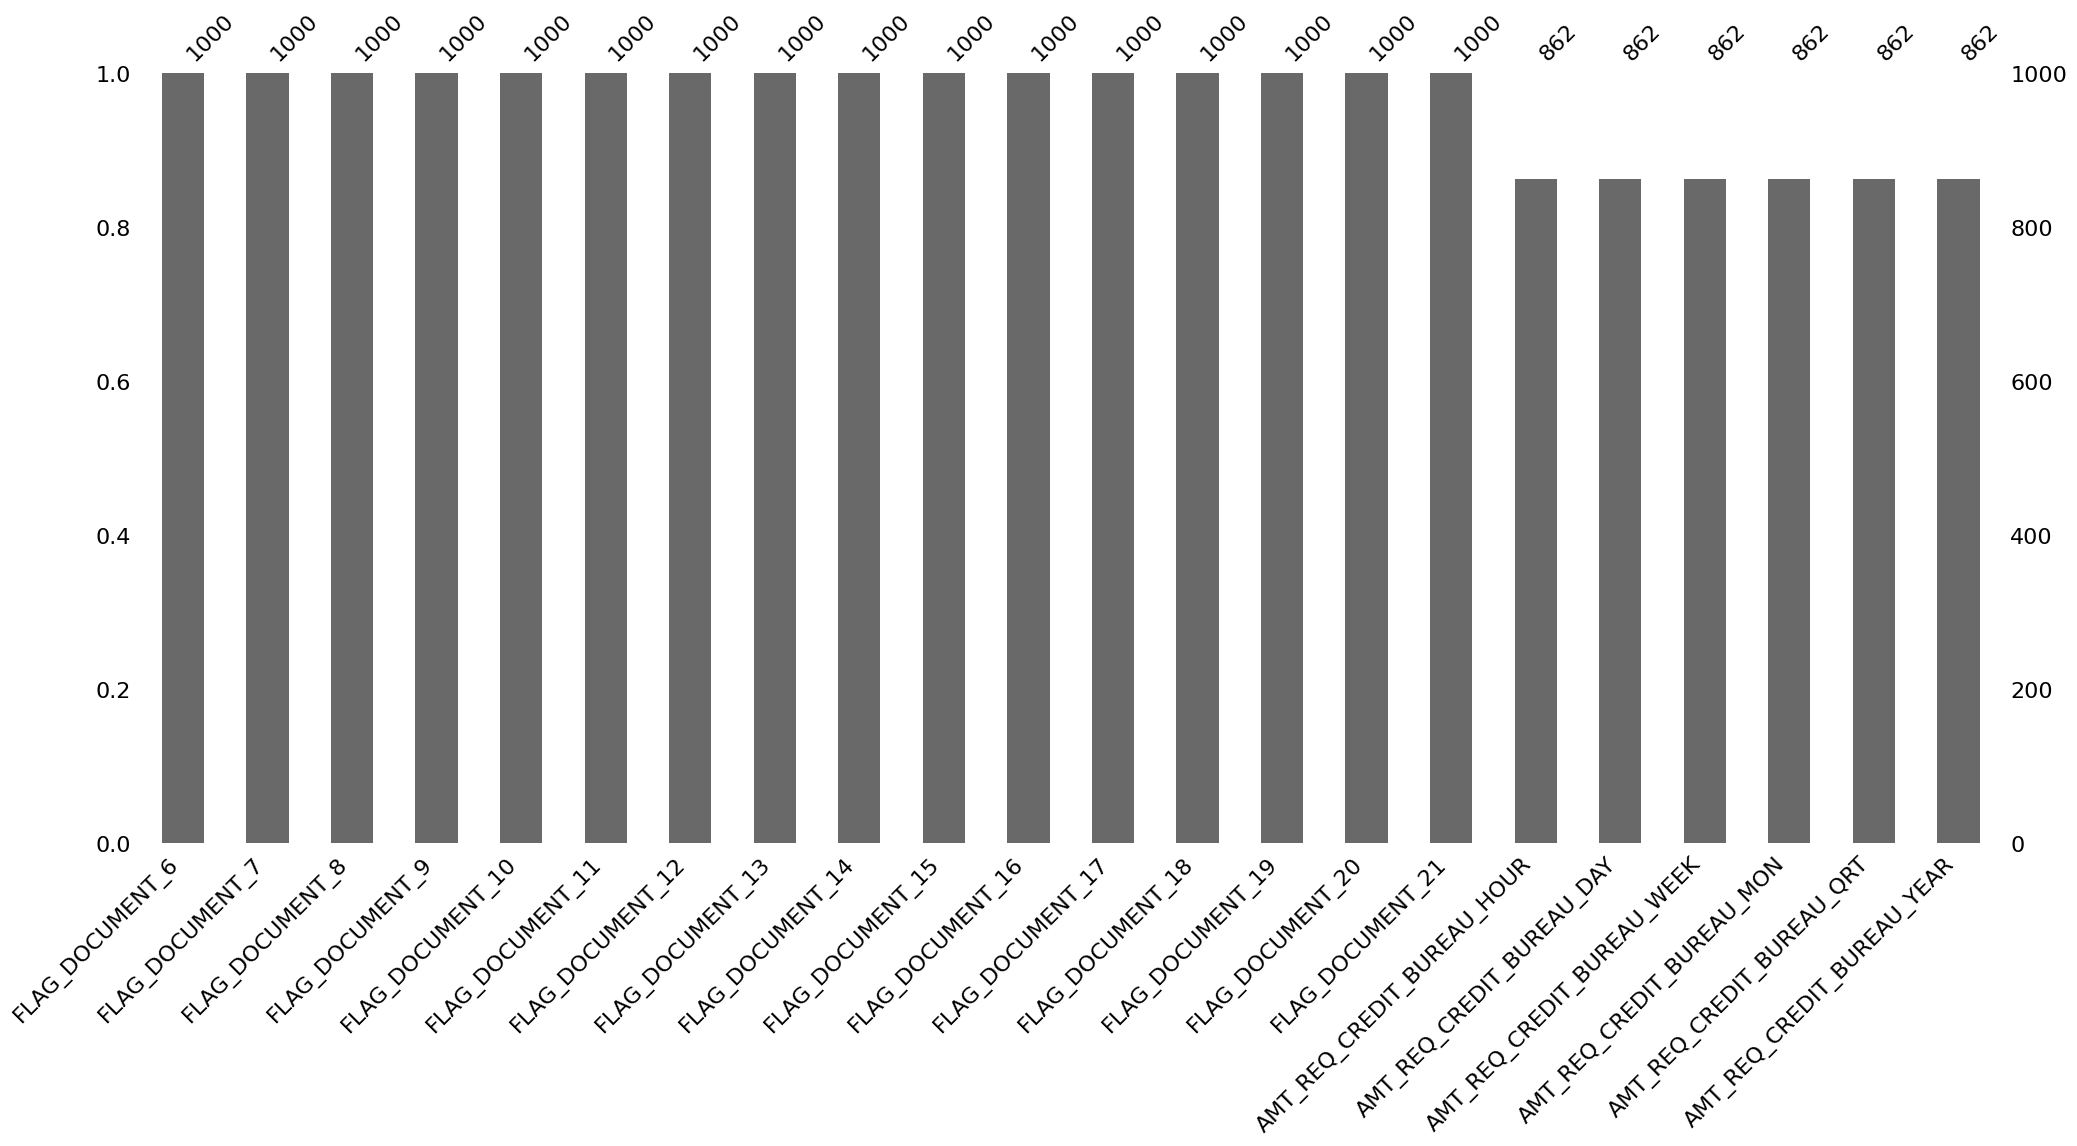

In [43]:
msno.bar(df_app.iloc[:, 100:].sample(1000))

In [44]:
df_app['SK_ID_CURR'].duplicated().sum()

0

## EDA

### Analyse de Target

[Text(0, 0, '91.93 %'), Text(0, 0, '8.07 %')]

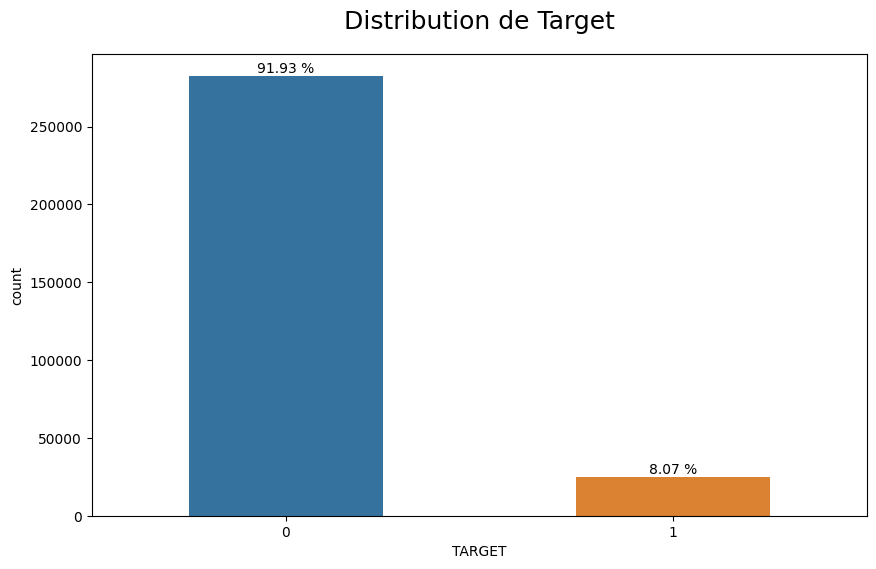

In [45]:
# Affichage de la distribution de notre cible
# 0 : pas de problème de remboursement du crédit
# 1 : difficulté a rembourser

fig, ax = plt.subplots(figsize = (10,6))

data = df_app.copy()

sns.countplot(ax = ax, data = data, x='TARGET', width = 0.5, saturation = 0.7)

ax.set_title('Distribution de Target', fontsize = 18, pad = 18)

bar_lbl = ax.containers[0].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[0], labels = bar_lbl)

Distribution des classes déséquilibrées

[Text(0, 0, '61.23 %'), Text(0, 0, '4.61 %')]

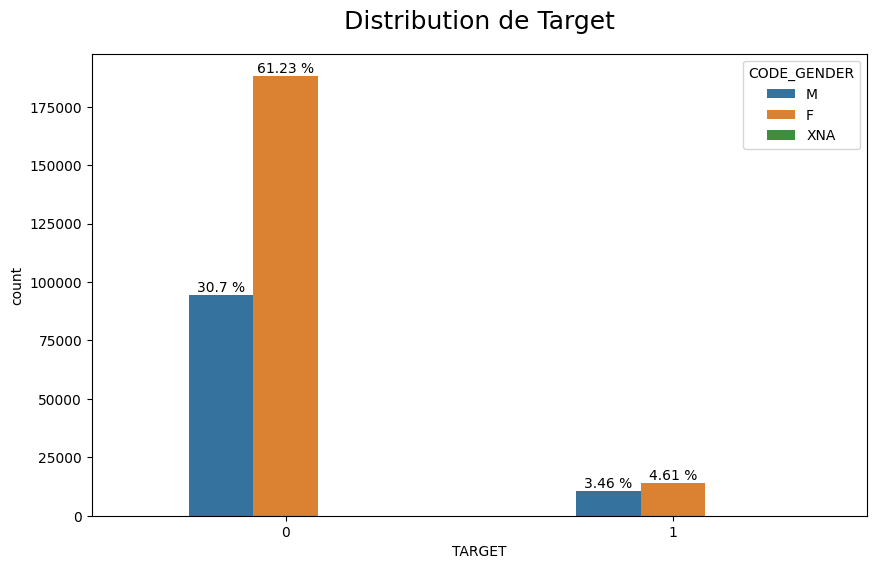

In [46]:
fig, ax = plt.subplots(figsize = (10,6))

data = df_app.copy()

sns.countplot(ax = ax, data = data, x='TARGET', hue='CODE_GENDER', width = 0.5, saturation = 0.7)

ax.set_title('Distribution de Target', fontsize = 18, pad = 18)

bar_lbl = ax.containers[0].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[0], labels = bar_lbl)

bar_lbl = ax.containers[1].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[1], labels = bar_lbl)

In [47]:
df_app.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

## Feature Engineering

In [48]:
# Utilisation d'un kernel kaggle pour le feature engineering
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

num_rows = None
nan_as_category = False

start = time.time()
df_to_export = utils.application_train_test(num_rows)

bureau = utils.bureau_and_balance(num_rows, nan_as_category)
print("Bureau df shape:", bureau.shape)
df_to_export = df_to_export.join(bureau, how='left', on='SK_ID_CURR')


prev = utils.previous_applications(num_rows, nan_as_category)
print("Previous applications df shape:", prev.shape)
df_to_export = df_to_export.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = utils.pos_cash(num_rows, nan_as_category)
print("Pos-cash balance df shape:", pos.shape)
df_to_export = df_to_export.join(pos, how='left', on='SK_ID_CURR')
del pos

ins = utils.installments_payments(num_rows, nan_as_category)
print("Installments payments df shape:", ins.shape)
df_to_export = df_to_export.join(ins, how='left', on='SK_ID_CURR')
del ins

cc = utils.credit_card_balance(num_rows, nan_as_category)
print("Credit card balance df shape:", cc.shape)
df_to_export = df_to_export.join(cc, how='left', on='SK_ID_CURR')
del cc

# drop de qqs rows avec des valeurs np.inf
avt = df_to_export.shape[0]
df_to_export.drop(df_to_export.iloc[df_to_export.values==np.inf].index, 
                  inplace=True)
aprs = df_to_export.shape[0]
print("Drop de {} rows ayant des valeurs anormales.".format(avt - aprs))

# drop des colonnes avec plus de 80% de valeurs manquantes
# (threshold à ajuster plus tard)
th_nan = 0.2
avt = df_to_export.shape[1]
df_to_export.dropna(thresh=df_to_export.shape[0]*th_nan, axis=1, inplace=True)
aprs = df_to_export.shape[1]
print("Drop de {} colonnes possedant plus de {}% de valeurs manquantes.".format(avt - aprs, (1 - th_nan)*100))

# Séparation des deux datasets
train_df = df_to_export[df_to_export['TARGET'].notnull()]
test_df = df_to_export[df_to_export['TARGET'].isnull()]

# On remet TARGET en integer (changement du à la concaténation
# avec le dataset test qui n'a pas de colonne TARGET)
# et qq cols mal typées
train_df = train_df.astype({'TARGET': 'int64', 
                            'DAYS_BIRTH': 'float64',
                            'DAYS_ID_PUBLISH': 'float64'})
test_df = test_df.astype({'DAYS_BIRTH': 'float64',
                          'DAYS_ID_PUBLISH': 'float64'})

tps_traitement = np.round(time.time() - start, 2)

print('--------------------------')
print('Temps total du feature engineering: {}s'.format(tps_traitement))
print('Dataframe finale shape')
print('Train dataset :{}'.format(train_df.shape))
print('Test dataset :{}'.format(test_df.shape))
      
print(train_df['TARGET'].value_counts(normalize=True))

Train size: 307511
Test size: 48744


C:\Users\julie\OpenClassrooms\Projet_7\utils.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_test).reset_index()


Bureau df shape: (305811, 112)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)
Drop de 20 rows ayant des valeurs anormales.
Drop de 7 colonnes possedant plus de 80.0% de valeurs manquantes.
--------------------------
Temps total du feature engineering: 101.0s
Dataframe finale shape
Train dataset :(307488, 787)
Test dataset :(48743, 787)
0    0.919272
1    0.080728
Name: TARGET, dtype: float64


## Feature Selection

Réduction du nombre de variables en supprimant celles qui ont une variance très faible.

In [49]:
X = train_df.drop(['TARGET', 'index', 'SK_ID_CURR'], axis=1)

th = 0.001
var_selector = VarianceThreshold(th)
var_selector.set_output(transform='pandas')
X_reduced = var_selector.fit_transform(X)

X_reduced.shape

(307488, 642)

Analyse importance des features basés sur test statistique

In [50]:
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer())
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent'))
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))


In [51]:
X_red_imp = preprocessor.fit_transform(X_reduced)
names = preprocessor.get_feature_names_out()
feature_names = []
for name in names:
    name1 = name.replace('pipeline-1__', '')
    name2 = name1.replace('pipeline-2__', '')
    feature_names.append(name2)

X_red_imp_df = pd.DataFrame(X_red_imp, columns=feature_names)
y = train_df['TARGET']

selector = SelectKBest(mutual_info_classif, k=200)
selector.set_output(transform='pandas')
X_test = selector.fit_transform(X_red_imp_df, y)

print(X_test.shape)

(307488, 200)


Text(0.5, 1.0, 'Feature importance basé sur mutual_info_classif')

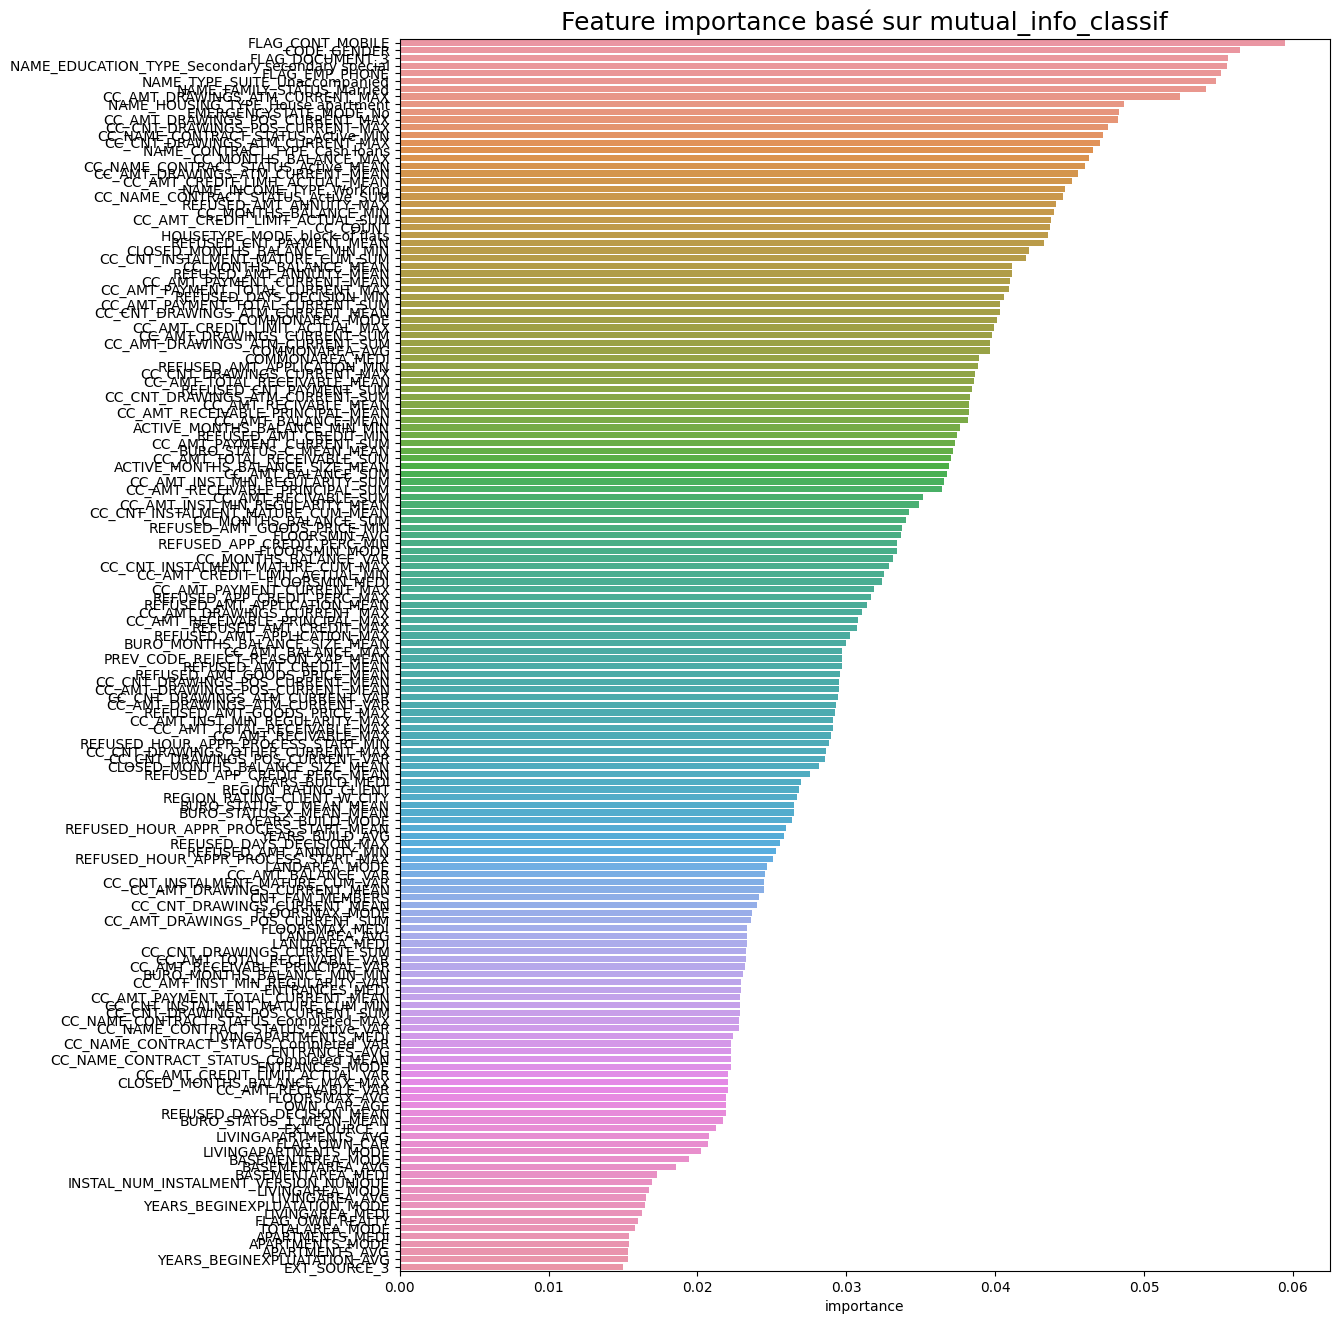

In [53]:
idx = np.argsort(-1*selector.scores_)
d = {'feature' : selector.feature_names_in_[idx],
     'importance' : selector.scores_[idx]
    }
best_features = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x="importance", y="feature", data=best_features.iloc[:160,:])
ax.set_ylabel(None)
ax.set_title('Feature importance basé sur mutual_info_classif',  fontsize = 18)

Analyse corrélation entre nos variables.
On cherche à supprimer les variables trop corrélées entre elles,
en conservant celle qui a eu le meilleur score (mutual_info_classif).

In [58]:
feature_names

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_B

In [60]:
X_test.head()

,FLAG_CONT_MOBILE,CODE_GENDER,FLAG_DOCUMENT_3,NAME_EDUCATION_TYPE_Secondary secondary special,FLAG_EMP_PHONE,NAME_TYPE_SUITE_Unaccompanied,NAME_FAMILY_STATUS_Married,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,NAME_HOUSING_TYPE_House apartment,EMERGENCYSTATE_MODE_No,...,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_BALANCE_MIN,CC_NAME_CONTRACT_STATUS_Completed_SUM,NONLIVINGAPARTMENTS_MEDI,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,NONLIVINGAPARTMENTS_AVG,PREV_NAME_PORTFOLIO_POS_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MAX
0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,106145.826721,1.0,1.0,...,1.533995e+09,10807.568396,1.151013,0.000000,10390.735126,9006.894904,1.000000,0.000000,1.000000,0.049367
1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,106145.826721,1.0,1.0,...,1.533995e+09,10807.568396,1.151013,0.003900,10390.735126,9006.894904,0.666667,0.003900,0.666667,0.049367
2,1.0,0.0,0.0,1.0,1.0,1.0,0.0,106145.826721,1.0,0.0,...,1.533995e+09,10807.568396,1.151013,0.008651,10390.735126,9006.894904,1.000000,0.008808,1.000000,0.049367
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,106145.826721,1.0,0.0,...,0.000000e+00,0.000000,0.000000,0.008651,0.000000,0.000000,0.555556,0.008808,0.222222,0.000000
4,1.0,0.0,0.0,1.0,1.0,1.0,0.0,106145.826721,1.0,0.0,...,1.533995e+09,10807.568396,1.151013,0.008651,10390.735126,9006.894904,0.333333,0.008808,0.333333,0.049367


In [59]:
X_test = X_test.reindex(columns=best_features.iloc[:200,0].values)

In [61]:
corr_matrix = X_test.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('There are %d columns to remove.' % (len(to_drop)))
print(to_drop)

final_feats = [col for col in X_test.columns if col not in to_drop]
print("Nombre de features retenues au final : {}".format(len(final_feats)))

There are 80 columns to remove.
['CC_MONTHS_BALANCE_MIN', 'CC_COUNT', 'HOUSETYPE_MODE_block of flats', 'CC_MONTHS_BALANCE_MEAN', 'REFUSED_AMT_ANNUITY_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CC_AMT_DRAWINGS_CURRENT_SUM', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'CC_AMT_RECIVABLE_MEAN', 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'CC_AMT_BALANCE_MEAN', 'REFUSED_AMT_CREDIT_MIN', 'CC_AMT_PAYMENT_CURRENT_SUM', 'CC_AMT_BALANCE_SUM', 'CC_AMT_INST_MIN_REGULARITY_SUM', 'CC_AMT_RECEIVABLE_PRINCIPAL_SUM', 'CC_AMT_RECIVABLE_SUM', 'CC_AMT_INST_MIN_REGULARITY_MEAN', 'CC_CNT_INSTALMENT_MATURE_CUM_MEAN', 'CC_MONTHS_BALANCE_SUM', 'REFUSED_AMT_GOODS_PRICE_MIN', 'FLOORSMIN_MODE', 'CC_MONTHS_BALANCE_VAR', 'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'FLOORSMIN_MEDI', 'CC_AMT_PAYMENT_CURRENT_MAX', 'REFUSED_AMT_APPLICATION_MAX', 'CC_AMT_BALANCE_MAX', 'REFUSED_AMT_CREDIT_MEAN', 'REFUSED_AMT_GOODS_PRICE_MEAN', 'REFUSED_AMT_GOODS_PRICE_MAX', 'CC_AMT_INST_MIN_REGULARITY_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_RECIVABLE_MAX',

## Sauvegarde des datasets

In [62]:
train_df = train_df[['SK_ID_CURR', 'TARGET'] + final_feats]
test_df = test_df[['SK_ID_CURR'] + final_feats]

train_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307488 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                                           Non-Null Count   Dtype  
---   ------                                           --------------   -----  
 0    SK_ID_CURR                                       307488 non-null  int64  
 1    TARGET                                           307488 non-null  int64  
 2    FLAG_CONT_MOBILE                                 307488 non-null  int64  
 3    CODE_GENDER                                      307488 non-null  int64  
 4    FLAG_DOCUMENT_3                                  307488 non-null  int64  
 5    NAME_EDUCATION_TYPE_Secondary secondary special  307488 non-null  uint8  
 6    FLAG_EMP_PHONE                                   307488 non-null  int64  
 7    NAME_TYPE_SUITE_Unaccompanied                    307488 non-null  uint8  
 8    NAME_FAMILY_STATUS_Married                       307488 non-null  uint8  
 9    CC

In [63]:
train_df.to_csv('Data/train.csv', index=False)
test_df.to_csv('Data/test.csv', index=False)

In [64]:
smpl = train_df.sample(frac=0.2)
smpl.to_csv('streamlit_dashboard/data_streamlit.csv', index=False)

---